In [1]:
%matplotlib inline

import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
import statsmodels.api as sm
import unidecode
from IPython.display import display
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    auc,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

plt.rcParams["figure.figsize"] = (15, 6.75)
plt.rcParams["font.family"] = "Courier New"
plt.rcParams["axes.titleweight"] = "bold"
plt.style.use("default_light.mplstyle")

pd.set_option("display.max_rows", 1000)
warnings.filterwarnings("ignore")

# !!change data folder!!
DATA_FOLDER = "../data/"
RESULTS_FOLDER = "../results/"

SAVE_RESULTS = True
PLOTS_EXT = ".png"
DPI = 150

ALPHA = 0.05

/Users/nikola/.virtualenvs/cardio/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
def sanitize_df(df):
    """
    Strips strings from spaces, numbers to floats.
    """
    for col_name, col_series in df.iteritems():
        if col_series.apply(type).eq(str).all():
            df[col_name] = col_series.str.strip()
        if (
            col_series.apply(type).eq(float).all()
            or col_series.apply(type).eq(int).all()
        ):
            df[col_name] = col_series.astype(float)
        # change Ano/Nie to bools
        df = df.replace({"Áno": True, "Nie": False})
    return df


# !!change data files!!
data = pd.read_excel(
    os.path.join(DATA_FOLDER, "Pacienti_30&30_na analyzu.xlsx"), sheet_name=None
)
# no AF
df1 = data["Bez Afib (30)_matched "]
noAF = sanitize_df(df1[df1["Typ"] == "Bez fibrilácie"])
# AF matched
df2 = data["S AF_matched to Bez Afib (30) "]
yesAF = sanitize_df(df2[(df2["Kód"].isin(noAF["Match"]))])
healthy_controls = pd.read_excel(os.path.join(DATA_FOLDER, "Healthy_control.xlsx"))

# check noAF "Match" matches yesAF "Kod"
assert all(noAF["Match"].values == yesAF["Kód"].values)
# check yesAF "Match" matches noAF "Kod"
assert all(yesAF["Match"].values == noAF["Kód"].values)

# merge
df = pd.concat([yesAF, noAF])
assert len(df) == 60

# birth (year is ok) - from Patient code
df["Rok narodenia"] = df["Kód"].apply(lambda x: int(x[2:4]) + 1900)
df["Vek"] = (2020 - df["Rok narodenia"]).astype(np.floating)
df = df.drop(["Rok narodenia"], axis=1)

In [3]:
## helper functions
REMOVE_COLS = [
    "Unnamed: 138",
    "Kód pacienta",
    "o. Warfarín",
    "r. Apixaban",
    "p.\tDabigatran etexilat",
]


def bivariate_analysis(
    data,
    columns,
    exclude_cols=None,
    match_col="Typ",
    match_vals=["Bez fibrilácie", "S fibriláciou"],
):
    exclude_cols = exclude_cols or []
    assert len(match_vals) == 2
    bivar = pd.DataFrame()
    for col in columns:
        if col in exclude_cols:
            continue
        col1 = data[data[match_col] == match_vals[0]][col]
        col2 = data[data[match_col] == match_vals[1]][col]
        if data[col].dtype == np.number:
            if pg.normality(data[col]).iloc[0, 2]:
                test = pg.ttest(
                    col1,
                    col2,
                )
                row = pd.DataFrame(
                    {
                        "test": "t-test",
                        "statistic value": test.iloc[0, 0],
                        "p-value": test.iloc[0, 3],
                    },
                    index=[col],
                )
            else:
                test = pg.mwu(
                    col1,
                    col2,
                )
                row = pd.DataFrame(
                    {
                        "test": "MWU",
                        "statistic value": test.iloc[0, 0],
                        "p-value": test.iloc[0, 2],
                    },
                    index=[col],
                )
            row.loc[
                col, f"{match_col}: {match_vals[0]}"
            ] = f"{np.nanmean(col1):.2f} $\pm$ {np.nanstd(col1):.2f}"
            row.loc[
                col, f"{match_col}: {match_vals[1]}"
            ] = f"{np.nanmean(col2):.2f} $\pm$ {np.nanstd(col2):.2f}"
        else:
            _, _, stats_ = pg.chi2_independence(x=col, y=match_col, data=data)
            row = pd.DataFrame(
                {
                    "test": "chi2 indipendence",
                    "statistic value": stats_.iloc[-1, 2],
                    "p-value": stats_.iloc[-1, 4],
                },
                index=[col],
            )
            row.loc[col, f"{match_col}: {match_vals[0]}"] = np.nansum(col1)
            row.loc[col, f"{match_col}: {match_vals[1]}"] = np.nansum(col2)

        bivar = pd.concat([bivar, row], axis=0)
    return bivar


def prepare_df(orig_df, predictors):
    df = orig_df.copy()
    # prepare
    df_logres = (
        df[predictors]
        .replace(
            {
                "S fibriláciou": 1,
                "Bez fibrilácie": 0,
                "Neprítomná": 0,
                "I.\tstupňa": 1,
                "II.\tstupňa": 2,
                "III.\tstupňa": 3,
                True: 1,
                False: 0,
                "Muž": 1,
                "Žena": 0,
            }
        )
        .rename(columns={"Typ": "AFib"})
    )
    # sanitize col names
    df_logres.columns = [
        "".join(
            filter(
                str.isalpha,
                unidecode.unidecode(col.title().replace(" ", "").replace("-", "")),
            )
        )
        for col in df_logres.columns
    ]
    cols = pd.Series(df_logres.columns)
    for dup in df_logres.columns[df_logres.columns.duplicated(keep=False)]:
        cols[df_logres.columns.get_loc(dup)] = [
            dup + str(d_idx) if d_idx != 0 else dup
            for d_idx in range(df_logres.columns.get_loc(dup).sum())
        ]
    df_logres.columns = cols

    # sanitize values
    df_logres = df_logres.dropna(axis=0)
    df_logres = df_logres.loc[:, df_logres.std() > 0.0]
    # scaler
    scaler = StandardScaler()
    float_cols = df_logres.select_dtypes([np.floating]).columns
    df_logres[float_cols] = scaler.fit_transform(df_logres[float_cols])

    return df_logres


def logres_statsmodels(df):
    model_def = "Afib ~ "
    for col in list(set(df.columns) - set(["Afib"])):
        if df[col].dtype == np.floating:
            model_def += col
        else:
            model_def += f"C({col})"
        model_def += " + "
    model_def = model_def[:-3]

    # init statsmodels logres with GLM and binomial family
    model = sm.GLM.from_formula(model_def, family=sm.families.Binomial(), data=df)
    result = model.fit()
    return result


def get_cols_by_type(data, col_types=[np.number, np.bool], nans_thresh="any"):
    if nans_thresh == "any":
        drop_kw = {"how": "any"}
    elif isinstance(nans_thresh, int):
        drop_kw = {"thresh": nans_thresh}
    columns = set(data.select_dtypes(col_types).dropna(axis=1, **drop_kw).columns)
    return columns - set(REMOVE_COLS)


def statsmodels_summary_to_df(results):
    results_df = pd.DataFrame(
        {
            "coef": results.params,
            "z": results.tvalues,
            "p-value": results.pvalues,
            "CI [0.025": results.conf_int()[0],
            "0.975]": results.conf_int()[1],
        }
    )
    return results_df

## Basic data description

In [4]:
VALUES_REPLACES = {
    "Zle kontrolovaná (sTK nad 160 mmHg)": True,
    "Dobre kontrolovaná": False,
    ">50%": False,
    "40-49%": True,
    "Neprítomná": 0.0,
    "I.\tstupňa": 1.0,
    "II.\tstupňa": 2.0,
    "III.\tstupňa": 3.0,
    "None": False,
}
RENAME_COLS = {"Počet": "i. Ischemická CMP/TIA"}

cont_cols = [
    "Hmotnosť",
    "Výška",
    "Vek",
    "BMI",
    "Tlak krvi systolický",
    "Tlak krvi diastolický",
    "Kreatinin (µmol/l)",
    "Klírens kreatinínu",
    "Trvanie AFib (mesiace)",
    "Počet",  # "i. Ischemická CMP/TIA"
    "i. STE – Infarkt myokardu",
    "ii. NSTE – Infarkt myokardu",
    "b. Diastolická dysfunkcia",
    "c. End-diastolický priemer ľavej komory (mm)",
    "d. Priemer ľavej predsiene v PLAX (parasternal short axis) (mm)",
    "D–dimér [ug/ml]",
    "Fibrinogén [g/l]",
    "CRP [mg/l]",
    "NT-proBNP  [ng/l]",
    "Hs-troponín [ng/l]",
    "Apelin[ng/ml]",
]

bool_cols = [
    "Pohlavie",
    "Diabetes mellitus.1",
    "Fajčenie (> 5 cigariet denne).1",
    "Cievna mozgová príhoda/TIA/systémový tromboembolizmus",
    "Betablokátory.1",
    "Supraventrikulárne extrasystoly",
    "Flutter predsiení",
    "Iná supraventrikulárna arytmia",
    "Komorová tachykardia / komorová fibrilácia",
    "a.\tArteriálna hypertenzia",
    "Arteriálna hypertenzia",
    "b.\tCievna mozgová príhoda/systémový tromboembolizmus",
    "ii. Hemoragická CMP",
    "iii. Systémový tromboembolizmus",
    "c. Pľúcna embólia",
    "d. Hlboká žilová trombóza",
    "e. Periférne artériové ochorenie/aortálny plát",
    "g. Známky srdcového zlyhávania",
    "ii. Ejekčná frakcia ľavej komory",
    "iii. Diastolická dysfunkcia",
    "iv. Hypertrofia ľavej komory",
    "v. Dilatácia ľavej predsiene",
    "i. Stabilná koronárna choroba ",
    "j. Nestabilná angina pectoris",
    "k. Infarkt myokardu ",
    "l. Chronická obštrukčná choroba pľúc",
    "m. Obštrukčné spánkové apnoe",
    "a. Elektrická kardioverzia",
    "b. Farmakologická kardioverzia",
    "c. ACE inhibítor/Blokátor angiotenzínových receptorov (ARB)",
    "d. Spironolakton/Eplerenon",
    "e. Beta blokátor",
    "f. Digoxin",
    "g. Amiodaron",
    "h. Dronedaron",
    "i. Inhibítor protónovej pumpy",
    "j. Antidepresíva / Antipsychotiká",
    "k. Kyselina acetylsalicylová",
    "l. Clopidogrel",
    "m. Prasugrel",
    "n. Ticagrelor",
    "o. Warfarín",
    "p.\tDabigatran etexilat",
    "q. Rivaroxaban",
    "r. Apixaban",
    "s. Edoxaban",
    "e. Chlopňová chyba",
    "f. Interventrikulárne septum/zadná stena > 10mm",
    "Kardiomyopatia",
    "Tyreotoxikóza",
    "Renálna insuficiencia K/DIGO G4-5 (Dialýza/St.p. transplantácii/CrCl < 0,5ml/s)",
    "Ochorenie pečene (Cirhóza/Transaminázy > 3x HLN/Bilirubin > 2x HLN)",
    "Abuzus alkoholu (≥8 „drinkov“ za týždeň)",
    "Tehotenstvo",
    "Kardiochirurgický výkon menej než 3 mesiace pred zaradením do štúdie",
    "Apelin[ng/ml]",
]


def mean_std_str(x):
    return f"{np.nanmean(x):.2f} $\pm$ {np.nanstd(x):.2f}"


def perc_str(x):
    sum_ = np.nansum(x)
    return f"{sum_} ({(sum_ / len(x)) * 100.0:.1f}%)"


## continuous
df_stats = df[cont_cols + ["Typ"]].rename(columns=RENAME_COLS).replace(VALUES_REPLACES)

# compute agg
stats = df_stats.groupby("Typ").agg(mean_std_str).T
# p-values
for col in df_stats:
    if (col == "Typ") or (col == "Trvanie AFib (mesiace)"):
        continue
    if pg.normality(df_stats[col]).iloc[0, 2]:
        pval = pg.ttest(
            df_stats[df_stats["Typ"] == "Bez fibrilácie"][col],
            df_stats[df_stats["Typ"] == "S fibriláciou"][col],
        ).iloc[0, 3]
        stats.loc[col, "p-value"] = pval
        stats.loc[col, "test"] = "t-test"
    else:
        pval = pg.mwu(
            df_stats[df_stats["Typ"] == "Bez fibrilácie"][col],
            df_stats[df_stats["Typ"] == "S fibriláciou"][col],
        ).iloc[0, 2]
        stats.loc[col, "p-value"] = pval
        stats.loc[col, "test"] = "MWU"


## boolean
df_stats = df[bool_cols + ["Typ"]].replace(VALUES_REPLACES)
df_stats = df_stats.replace({"Muž": True, "Žena": False})
# compute agg
bool_stats = df_stats.groupby("Typ").agg(perc_str).T
# p-values
for col in df_stats.columns:
    if col == "Typ":
        continue
    _, _, stats_ = pg.chi2_independence(x=col, y="Typ", data=df_stats)
    pval = stats_["pval"].min()
    bool_stats.loc[col, "p-value"] = pval
    bool_stats.loc[col, "test"] = "chi2"

stats = pd.concat([stats, bool_stats], axis=0)
if SAVE_RESULTS:
    stats.round(3).to_csv(os.path.join(RESULTS_FOLDER, "basic_stats.csv"))
stats.round(3)

Typ,Bez fibrilácie,S fibriláciou,p-value,test
Hmotnosť,83.93 $\pm$ 12.20,82.63 $\pm$ 15.89,0.728,t-test
Výška,170.57 $\pm$ 9.04,171.10 $\pm$ 9.68,0.829,t-test
Vek,71.83 $\pm$ 8.00,73.63 $\pm$ 7.40,0.378,t-test
BMI,28.86 $\pm$ 3.53,28.10 $\pm$ 4.09,0.450,t-test
Tlak krvi systolický,134.13 $\pm$ 12.48,131.37 $\pm$ 9.77,0.366,MWU
Tlak krvi diastolický,79.13 $\pm$ 7.23,75.70 $\pm$ 8.36,0.214,MWU
Kreatinin (µmol/l),82.00 $\pm$ 15.80,85.42 $\pm$ 16.53,0.425,MWU
Klírens kreatinínu,1.25 $\pm$ 0.21,1.20 $\pm$ 0.22,0.376,t-test
Trvanie AFib (mesiace),nan $\pm$ nan,29.85 $\pm$ 28.43,NaN,NaN
i. Ischemická CMP/TIA,1.14 $\pm$ 0.35,1.25 $\pm$ 0.43,0.677,MWU


In [5]:
df_compare = df[["Pohlavie", "Vek", "Apelin[ng/ml]", "Typ"]]
df_compare["Pohlavie"] = df_compare["Pohlavie"].apply(lambda x: x[0])
df_compare = df_compare.rename(columns={"Apelin[ng/ml]": "Apelin [ng/ml]"})
healthy_controls["Typ"] = "control"
df_compare = pd.concat([df_compare, healthy_controls], axis=0)

cont_cols = ["Vek", "Apelin [ng/ml]"]
bool_cols = ["Pohlavie"]

stats2 = df_compare[cont_cols + ["Typ"]].groupby("Typ").agg(mean_std_str).T
for col in cont_cols:
    pval = pg.anova(data=df_compare, dv=col, between="Typ").iloc[0, 4]
    stats2.loc[col, "p-value"] = pval
    stats2.loc[col, "test"] = "ANOVA"
# stats2.round(4)

_, _, chi_stats = pg.chi2_independence(data=df_compare, x="Pohlavie", y="Typ")
stats2_bool = (
    df_compare[bool_cols + ["Typ"]]
    .replace({"M": 1, "Ž": 0})
    .groupby("Typ")
    .agg(perc_str)
    .T
)
stats2_bool.loc["Pohlavie", "p-value"] = chi_stats["pval"].min()
stats2_bool.loc["Pohlavie", "test"] = "chi2"
stats2 = pd.concat([stats2, stats2_bool], axis=0)
if SAVE_RESULTS:
    stats2.round(4).to_csv(os.path.join(RESULTS_FOLDER, "basic_stats_w_control.csv"))
stats2.round(4)

Typ,Bez fibrilácie,S fibriláciou,control,p-value,test
Vek,71.83 $\pm$ 8.00,73.63 $\pm$ 7.40,41.03 $\pm$ 9.34,0.0000,ANOVA
Apelin [ng/ml],0.98 $\pm$ 0.45,0.69 $\pm$ 0.15,0.98 $\pm$ 0.06,0.0001,ANOVA
Pohlavie,19 (63.3%),19 (63.3%),13 (38.2%),0.0544,chi2


## Apelin differences between groups

* basic stats
* normality test (parametric vs. non-parametric ANOVA)
* equal variances test (Welch vs. classic ANOVA)
* ANOVA
* post-hoc
* boxplot with plotted significance

In [6]:
df_apelin = df_compare[["Apelin [ng/ml]", "Typ"]]
df_apelin.groupby("Typ").describe()

Apelin [ng/ml]                                               \
                        count      mean       std     min     25%      50%   
Typ                                                                          
Bez fibrilácie           30.0  0.975333  0.458239  0.3740  0.5960  0.92050   
S fibriláciou            29.0  0.694138  0.148219  0.4380  0.5930  0.70700   
control                  34.0  0.981697  0.059640  0.8683  0.9367  0.98625   

                                
                    75%    max  
Typ                             
Bez fibrilácie  1.32325  2.009  
S fibriláciou   0.74400  1.042  
control         1.02450  1.105

In [7]:
# normality - Shapiro-Wilk
df_apelin.loc[df_apelin["Typ"] == "S fibriláciou", "idx"] = np.arange(
    len(df_apelin[df_apelin["Typ"] == "S fibriláciou"])
)
df_apelin.loc[df_apelin["Typ"] == "Bez fibrilácie", "idx"] = np.arange(
    len(df_apelin[df_apelin["Typ"] == "Bez fibrilácie"])
)
df_apelin.loc[df_apelin["Typ"] == "control", "idx"] = np.arange(
    len(df_apelin[df_apelin["Typ"] == "control"])
)
df_apelin = df_apelin.pivot(values="Apelin [ng/ml]", columns="Typ", index="idx")
df_apelin = df_apelin.rename(
    columns={"S fibriláciou": "AFib", "Bez fibrilácie": "no AFib"}
)
pg.normality(df_apelin)

,W,pval,normal
Typ,,,
no AFib,0.926360,0.039337,False
AFib,0.974034,0.672975,True
control,0.976522,0.660576,True


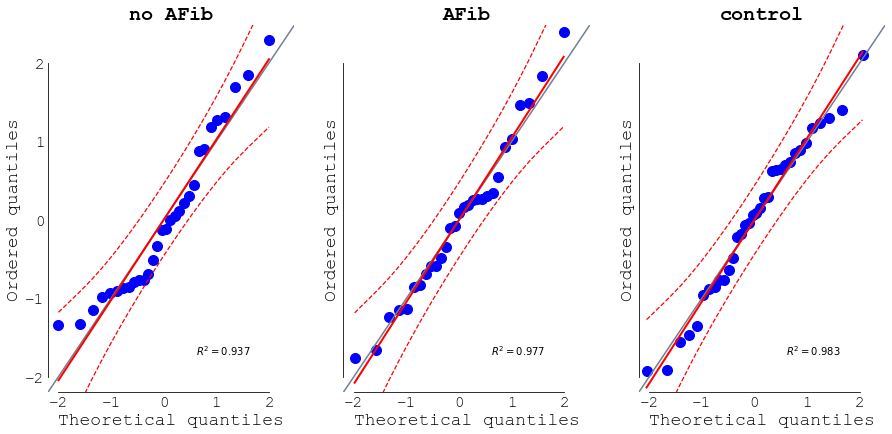

In [8]:
# normality Q-Q
_, axs = plt.subplots(1, 3, sharex=True, sharey=True)
for i, col in enumerate(df_apelin):
    pg.qqplot(df_apelin[col], "norm", ax=axs[i])
    sns.despine(trim=True)
    axs[i].set_title(col)
if SAVE_RESULTS:
    plt.savefig(
        os.path.join(RESULTS_FOLDER, "apelin_qqplot" + PLOTS_EXT),
        dpi=DPI,
        transparent=True,
        bbox_inches="tight",
    )

In [9]:
# equal variance test - Levene
pg.homoscedasticity(df_apelin.dropna()).round(3)

,W,pval,equal_var
levene,0.575,0.944,True


In [10]:
# ANOVA
df_apelin_anova_format = df_apelin.melt()
anova = pg.anova(data=df_apelin_anova_format, dv="value", between="Typ", detailed=False)
anova

,Source,ddof1,ddof2,F,p-unc,np2
0,Typ,2,90,10.665098,0.00007,0.191594


In [11]:
# compute power of ANOVA
pg.power_anova(eta=anova["np2"], k=df_apelin.shape[1], n=df_apelin.shape[0])

array([0.99444073])

In [12]:
posthoc = pg.pairwise_tukey(
    data=df_apelin_anova_format, dv="value", between="Typ", effsize="cohen"
)
if SAVE_RESULTS:
    posthoc.round(3).to_csv(os.path.join(RESULTS_FOLDER, "apelin_posthoc.csv"))
posthoc.round(3)

,A,B,mean(A),mean(B),diff,se,T,p-tukey,cohen
0,AFib,control,0.694,0.982,-0.288,0.070,-4.132,0.001,-1.044
1,AFib,no AFib,0.694,0.975,-0.281,0.072,-3.922,0.001,-1.021
2,control,no AFib,0.982,0.975,0.006,0.069,0.092,0.900,0.023


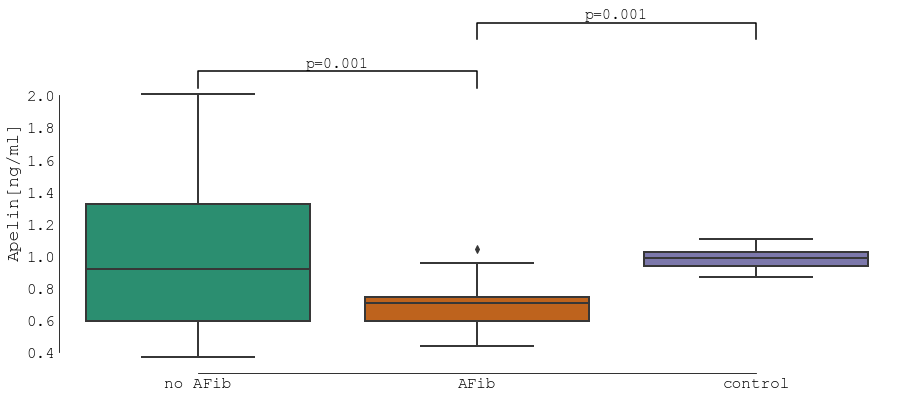

In [13]:
sns.boxplot(
    x="Typ",
    y="value",
    data=df_apelin_anova_format,
    palette=sns.color_palette("Dark2"),
)
plt.ylabel("Apelin[ng/ml]")
plt.xlabel("")
sns.despine(trim=True)

# plot significance from post-hoc
positions = {"AFib": 1, "no AFib": 0, "control": 2}
y = df_apelin_anova_format["value"].max() * 1.02
h = df_apelin_anova_format["value"].max() * 0.05
color = plt.rcParams["text.color"]
for _, row in posthoc[posthoc["p-tukey"] < ALPHA][::-1].iterrows():
    x1 = positions[row["A"]]
    x2 = positions[row["B"]]
    plt.gca().plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=color)
    text = text = f"p={row['p-tukey']:.3f}"
    plt.text(
        (x1 + x2) * 0.5,
        y + h * 1.1,
        text,
        ha="center",
        va="bottom",
        color=color,
        size=15,
    )
    y = y + h * 3

if SAVE_RESULTS:
    plt.savefig(
        os.path.join(RESULTS_FOLDER, "apelin_boxplot" + PLOTS_EXT),
        dpi=DPI,
        transparent=True,
        bbox_inches="tight",
    )

## Apelin correlations with other risk factors
* apelin vs. LA size
* apelin vs. NT-proBNP
* apelin vs. diastolic dysfunction correlation

In [14]:
def plot_corrs_as_reg(data, x_col, y_col, hue, rename=None, replace=None):
    df = data.copy()
    rename = rename or {}
    df = df.rename(columns=rename)
    replace = replace or {}
    df = df.replace(replace)
    g = sns.jointplot(data=df, x=x_col, y=y_col, hue=hue, palette="Dark2")
    sns.despine(trim=True)
    for col, (_, gr) in zip(sns.color_palette("Dark2", 2), df.groupby(hue)):
        sns.regplot(
            x=x_col,
            y=y_col,
            data=gr,
            scatter=False,
            ax=g.ax_joint,
            truncate=False,
            color=col,
        )
    if SAVE_RESULTS:
        plt.savefig(
            os.path.join(
                RESULTS_FOLDER, f"corrplot_{x_col[:5]}_vs_{y_col[:5]}" + PLOTS_EXT
            ),
            dpi=DPI,
            transparent=True,
            bbox_inches="tight",
        )


def get_corrs(data, x_col, y_col, hue):
    overall = pg.corr(data[x_col], data[y_col], method="spearman")
    overall.index = ["overall"]
    for gr_name, gr in data.groupby(hue):
        temp = pg.corr(gr[x_col], gr[y_col], method="spearman")
        temp.index = [gr_name]
        overall = pd.concat([overall, temp], axis=0)
    return overall

,n,r,CI95%,p-val,power
overall,59,-0.096738,"[-0.34, 0.16]",0.466080,0.112904
Bez fibrilácie,30,-0.082813,"[-0.43, 0.29]",0.663519,0.071677
S fibriláciou,29,-0.233578,"[-0.55, 0.15]",0.222661,0.233437


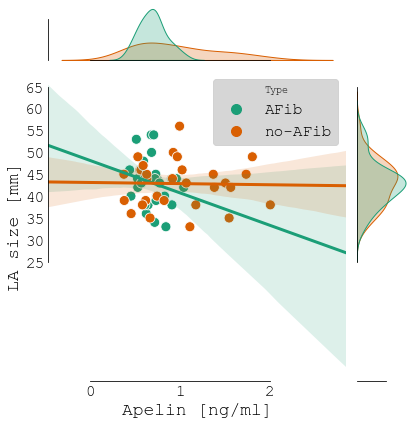

In [15]:
# LA size
plot_corrs_as_reg(
    data=df,
    x_col="Apelin [ng/ml]",
    y_col="LA size [mm]",
    hue="Type",
    rename={
        "d. Priemer ľavej predsiene v PLAX (parasternal short axis) (mm)": "LA size [mm]",
        "Typ": "Type",
        "Apelin[ng/ml]": "Apelin [ng/ml]",
    },
    replace={"Bez fibrilácie": "no-AFib", "S fibriláciou": "AFib"},
)
corrs = get_corrs(
    df,
    x_col="Apelin[ng/ml]",
    y_col="d. Priemer ľavej predsiene v PLAX (parasternal short axis) (mm)",
    hue="Typ",
)
if SAVE_RESULTS:
    corrs.round(3).to_csv(os.path.join(RESULTS_FOLDER, "ap_lasize_corr.csv"))
corrs

,n,r,CI95%,p-val,power
overall,59,-0.146905,"[-0.39, 0.11]",0.266875,0.199972
Bez fibrilácie,30,-0.033593,"[-0.39, 0.33]",0.860116,0.053086
S fibriláciou,29,-0.189186,"[-0.52, 0.19]",0.325658,0.167356


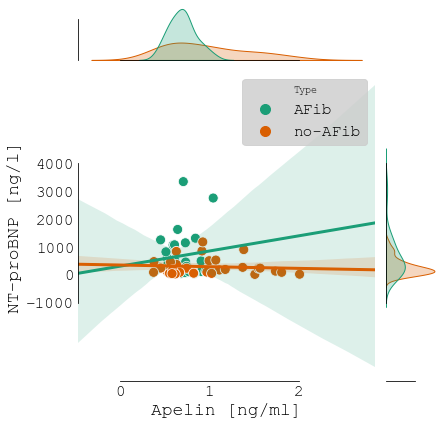

In [16]:
# NT-proBNP  [ng/l]
plot_corrs_as_reg(
    data=df,
    x_col="Apelin [ng/ml]",
    y_col="NT-proBNP [ng/l]",
    hue="Type",
    rename={
        "NT-proBNP  [ng/l]": "NT-proBNP [ng/l]",
        "Typ": "Type",
        "Apelin[ng/ml]": "Apelin [ng/ml]",
    },
    replace={"Bez fibrilácie": "no-AFib", "S fibriláciou": "AFib"},
)
corrs = get_corrs(
    df,
    x_col="Apelin[ng/ml]",
    y_col="NT-proBNP  [ng/l]",
    hue="Typ",
)
if SAVE_RESULTS:
    corrs.round(3).to_csv(os.path.join(RESULTS_FOLDER, "ap_ntprobnp_corr.csv"))
corrs

,n,r,CI95%,p-val,power
overall,59,-0.126096,"[-0.37, 0.13]",0.341278,0.159093
Bez fibrilácie,30,-0.213793,"[-0.53, 0.16]",0.256621,0.207920
S fibriláciou,29,0.058877,"[-0.31, 0.42]",0.761600,0.060190


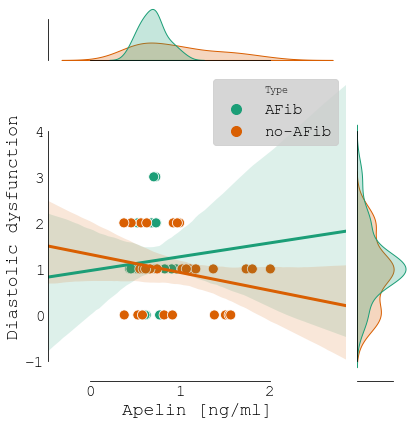

In [17]:
# diastolic dysfunction
df_dys = df.replace(
    {"Neprítomná": 0, "I.\tstupňa": 1, "II.\tstupňa": 2, "III.\tstupňa": 3}
)
plot_corrs_as_reg(
    data=df_dys,
    x_col="Apelin [ng/ml]",
    y_col="Diastolic dysfunction",
    hue="Type",
    rename={
        "b. Diastolická dysfunkcia": "Diastolic dysfunction",
        "Typ": "Type",
        "Apelin[ng/ml]": "Apelin [ng/ml]",
    },
    replace={"Bez fibrilácie": "no-AFib", "S fibriláciou": "AFib"},
)
corrs = get_corrs(
    df_dys,
    x_col="Apelin[ng/ml]",
    y_col="b. Diastolická dysfunkcia",
    hue="Typ",
)
if SAVE_RESULTS:
    corrs.round(3).to_csv(os.path.join(RESULTS_FOLDER, "ap_diadys_corr.csv"))
corrs

## Apelin predicts AF (AF vs non-AF patients)
* AUC analysis

In [18]:
# prepare
df_logres = df[["Apelin[ng/ml]", "Typ"]].dropna()
df_logres = df_logres.replace({"S fibriláciou": 0.0, "Bez fibrilácie": 1.0})


def manual_roc_curve(data, true_col, pred_col, thresholds):
    tpr = []
    fpr = []
    for thresh in thresholds:
        tn, fp, fn, tp = confusion_matrix(
            data[true_col], data[pred_col] > thresh
        ).ravel()
        tpr.append(tp / (tp + fn))
        fpr.append(fp / (fp + tn))
    return np.array(tpr), np.array(fpr)


def get_metrics_for_thresh(data, true_col, pred_col, thresh):
    print(f"Threshold: {thresh}")
    cm = confusion_matrix(data[true_col], data[pred_col] > thresh)
    total = sum(sum(cm))
    tp, fn, fp, tn = cm.ravel()

    display(
        pd.DataFrame(
            cm, columns=["predicted FIB", "predicted NO FIB"], index=["FIB", "NO FIB"]
        )
    )
    print("---------")
    accuracy = (tp + tn) / total
    print("Accuracy : ", accuracy)

    sensitivity = tp / (tp + fn)
    print("Sensitivity : ", sensitivity)

    specificity = tn / (tn + fp)
    print("Specificity : ", specificity)
    
    
def get_metrics_for_prediction(true, predicted):
    cm = confusion_matrix(true, predicted)
    total = sum(sum(cm))
    tp, fn, fp, tn = cm.ravel()

    display(
        pd.DataFrame(
            cm, columns=["predicted FIB", "predicted NO FIB"], index=["FIB", "NO FIB"]
        )
    )
    print("---------")
    accuracy = (tp + tn) / total
    print("Accuracy : ", accuracy)

    sensitivity = tp / (tp + fn)
    print("Sensitivity : ", sensitivity)

    specificity = tn / (tn + fp)
    print("Specificity : ", specificity)
    
    
def get_metrics_for_kfold(true, predicted):
    cm = confusion_matrix(true, predicted)
    total = sum(sum(cm))
    tp, fn, fp, tn = cm.ravel()
    accuracy = (tp + tn) / total
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    return accuracy, sensitivity, specificity
    


TRUE_COL = "Typ"
PRED_COL = "Apelin[ng/ml]"

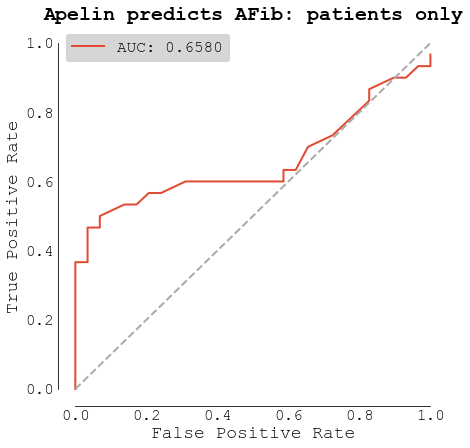

In [19]:
thresholds = np.linspace(df_logres[PRED_COL].min(), df_logres[PRED_COL].max(), 100)
tpr, fpr = manual_roc_curve(
    df_logres,
    true_col=TRUE_COL,
    pred_col=PRED_COL,
    thresholds=thresholds,
)
auc = np.abs(np.trapz(tpr, fpr))
plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr, label=f"AUC: {auc:.4f}")
plt.plot([0, 1], [0, 1], color="#AAAAAA", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Apelin predicts AFib: patients only")
plt.legend()
sns.despine(trim=True)
if SAVE_RESULTS:
    plt.savefig(
        os.path.join(RESULTS_FOLDER, "apelin_roc_patients" + PLOTS_EXT),
        dpi=DPI,
        transparent=True,
        bbox_inches="tight",
    )

In [20]:
ideal_threshold_pat = thresholds[np.argmax(tpr - fpr)]
get_metrics_for_thresh(
    df_logres, true_col=TRUE_COL, pred_col=PRED_COL, thresh=ideal_threshold_pat
)

Threshold: 0.9685454545454545


,predicted FIB,predicted NO FIB
FIB,28,1
NO FIB,16,14


---------
Accuracy :  0.711864406779661
Sensitivity :  0.9655172413793104
Specificity :  0.4666666666666667


## log Apelin predicts AF (AF vs non-AF patients)

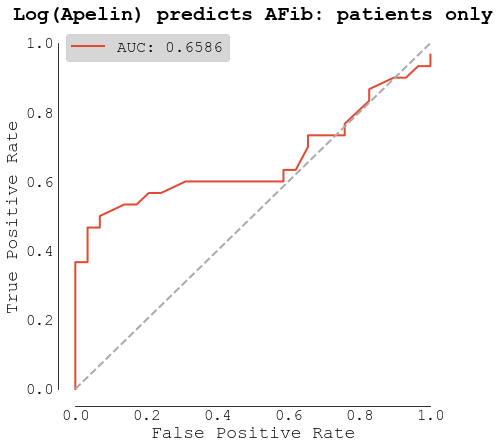

In [21]:
df_logres_log = df[["Apelin[ng/ml]", "Typ"]].dropna()
df_logres_log = df_logres_log.replace({"S fibriláciou": 0.0, "Bez fibrilácie": 1.0})
df_logres_log["Apelin[ng/ml]"] = np.log(df_logres_log["Apelin[ng/ml]"])

thresholds = np.linspace(
    df_logres_log[PRED_COL].min(), df_logres_log[PRED_COL].max(), 100
)
tpr, fpr = manual_roc_curve(
    df_logres_log,
    true_col=TRUE_COL,
    pred_col=PRED_COL,
    thresholds=thresholds,
)
auc = np.abs(np.trapz(tpr, fpr))
plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr, label=f"AUC: {auc:.4f}")
plt.plot([0, 1], [0, 1], color="#AAAAAA", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Log(Apelin) predicts AFib: patients only")
plt.legend()
sns.despine(trim=True)
if SAVE_RESULTS:
    plt.savefig(
        os.path.join(RESULTS_FOLDER, "log_apelin_roc_patients" + PLOTS_EXT),
        dpi=DPI,
        transparent=True,
        bbox_inches="tight",
    )

In [22]:
ideal_threshold_log = thresholds[np.argmax(tpr - fpr)]
get_metrics_for_thresh(
    df_logres_log, true_col=TRUE_COL, pred_col=PRED_COL, thresh=ideal_threshold_log
)

Threshold: -0.032553544452226024


,predicted FIB,predicted NO FIB
FIB,28,1
NO FIB,16,14


---------
Accuracy :  0.711864406779661
Sensitivity :  0.9655172413793104
Specificity :  0.4666666666666667


## Apelin predicts AF (including healthy controls)
* AUC analysis

In [23]:
df_logres_all = pd.DataFrame(columns=["apelin", "AF"])
for col in df_apelin:
    af = 0.0 if col == "AFib" else 1.0
    temp = pd.DataFrame({"apelin": df_apelin[col].dropna().values, "AF": af})
    df_logres_all = pd.concat([df_logres_all, temp], axis=0)

TRUE_COL = "AF"
PRED_COL = "apelin"

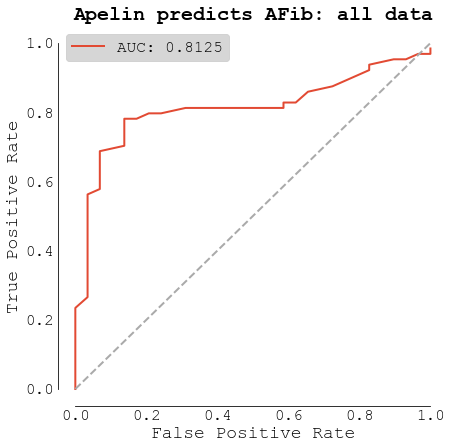

In [24]:
thresholds = np.linspace(
    df_logres_all[PRED_COL].min(), df_logres_all[PRED_COL].max(), 100
)
tpr, fpr = manual_roc_curve(
    df_logres_all,
    true_col=TRUE_COL,
    pred_col=PRED_COL,
    thresholds=thresholds,
)
auc = np.abs(np.trapz(tpr, fpr))
plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr, label=f"AUC: {auc:.4f}")
plt.plot([0, 1], [0, 1], color="#AAAAAA", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Apelin predicts AFib: all data")
plt.legend()
sns.despine(trim=True)
if SAVE_RESULTS:
    plt.savefig(
        os.path.join(RESULTS_FOLDER, "apelin_roc_all" + PLOTS_EXT),
        dpi=DPI,
        transparent=True,
        bbox_inches="tight",
    )

In [25]:
ideal_threshold_all = thresholds[np.argmax(tpr - fpr)]
get_metrics_for_thresh(
    df_logres_all, true_col=TRUE_COL, pred_col=PRED_COL, thresh=ideal_threshold_all
)

Threshold: 0.8529393939393939


,predicted FIB,predicted NO FIB
FIB,25,4
NO FIB,14,50


---------
Accuracy :  0.8064516129032258
Sensitivity :  0.8620689655172413
Specificity :  0.78125


## Exploratory analysis of no-AFib differences
* take two groups: no-AFib with Apelin < `ideal_threshold`, i.e. patients WITHOUT AFib and WITH low Apelin (those would be classified as AFib) by our dummy classifier
* second groupd is NO AFib and high Apelin, i.e. correctly classified as no-AFib by our dummy classifier

In [26]:
df_nofib = df[df["Typ"] == "Bez fibrilácie"]
df_nofib["Apelin_low"] = df_nofib["Apelin[ng/ml]"] < ideal_threshold_pat

bivar_nofib = bivariate_analysis(
    data=df_nofib,
    columns=get_cols_by_type(df_nofib, nans_thresh=20),
    exclude_cols=["Apelin_low"],
    match_col="Apelin_low",
    match_vals=[False, True],
)
# display ones with p-value < 0.5
if SAVE_RESULTS:
    bivar_nofib.round(3).to_csv(
        os.path.join(RESULTS_FOLDER, "bivar_noAFib_low_vs_high_apelin.csv")
    )
bivar_nofib[bivar_nofib["p-value"] < 0.5].round(3)

,test,statistic value,p-value,Apelin_low: False,Apelin_low: True
esRAGE[ng/ml],MWU,59.000,0.029,0.28 $\pm$ 0.08,0.49 $\pm$ 0.31
BCA[g/l],MWU,143.000,0.205,81.27 $\pm$ 13.07,74.91 $\pm$ 9.03
o. Fajčenie (> 5 cigariet denne),chi2 indipendence,0.903,0.342,2.0,0.0
AGEs[g/l],MWU,176.000,0.008,4.15 $\pm$ 1.04,2.97 $\pm$ 0.87
ACE – I.1,chi2 indipendence,0.528,0.468,14.0,14.0
Fajčenie (> 5 cigariet denne).1,chi2 indipendence,0.903,0.342,2.0,0.0
AGEs[rfu],MWU,185.000,0.003,22997.43 $\pm$ 5345.23,15723.25 $\pm$ 4899.60
Klírens kreatinínu,t-test,1.266,0.217,1.30 $\pm$ 0.22,1.20 $\pm$ 0.19
l. Clopidogrel,chi2 indipendence,0.468,0.494,2.0,5.0
MDA[umol/ml],MWU,182.000,0.004,338.11 $\pm$ 223.22,169.93 $\pm$ 67.62


### Compare only low Apelin group
* take only patients with Apelin < ideal_threshold (low apelin group) and compare AFib vs. no-AFib

In [27]:
df_lowap = df[df["Apelin[ng/ml]"] < ideal_threshold_pat]


bivar_low_apelin = bivariate_analysis(
    data=df_lowap,
    columns=get_cols_by_type(df_lowap, nans_thresh=5),
    exclude_cols=["Typ", "Trvanie AFib (mesiace)"],
)
if SAVE_RESULTS:
    bivar_low_apelin.round(3).to_csv(
        os.path.join(RESULTS_FOLDER, "bivar_lowApelin_AFib_vs_noAFib.csv")
    )
# display ones with p-value < 0.5
bivar_low_apelin[bivar_low_apelin["p-value"] < 0.5].round(3)

,test,statistic value,p-value,Typ: Bez fibrilácie,Typ: S fibriláciou
esRAGE[ng/ml],MWU,258.000,0.414,0.49 $\pm$ 0.31,0.40 $\pm$ 0.18
Tlak krvi diastolický,MWU,269.500,0.261,79.12 $\pm$ 6.40,76.11 $\pm$ 8.07
l. Chronická obštrukčná choroba pľúc,chi2 indipendence,4.047,0.044,0.0,5.0
i. Inhibítor protónovej pumpy,chi2 indipendence,4.173,0.041,2.0,12.0
l. Clopidogrel,chi2 indipendence,1.609,0.205,5.0,3.0
MDA[umol/ml],MWU,110.500,0.008,169.93 $\pm$ 67.62,265.76 $\pm$ 161.35
i. Elevácia NT-proBNP,chi2 indipendence,0.468,0.494,9.0,20.0
Hs-troponín [ng/l],MWU,172.500,0.213,11.28 $\pm$ 4.33,37.13 $\pm$ 100.25
Diastolická dysfunkcia (I-III. stupňa).1,chi2 indipendence,0.864,0.352,11.0,24.0
CRP [mg/l],MWU,118.500,0.008,2.33 $\pm$ 1.14,5.08 $\pm$ 5.47


## Logistic regression
* bivariate analysis
* variables with significant (p-value < $\alpha$) difference between AFib and no-AFib groups are added as predictors
* logistic regression of all data to find significant predictors
* ML-style logistic regression with Stratified K-Fold

In [28]:
# bivariate analysis
df_nans = df.replace(
    {
        "Neprítomná": 0,
        "I.\tstupňa": 1,
        "II.\tstupňa": 2,
        "III.\tstupňa": 3,
    }
)

overall = bivariate_analysis(
    data=df_nans,
    columns=get_cols_by_type(df_nans, nans_thresh=5),
    exclude_cols=["Typ", "Trvanie AFib (mesiace)"],
)
if SAVE_RESULTS:
    overall.round(3).to_csv(os.path.join(RESULTS_FOLDER, "bivar_AFib_vs_noAFib.csv"))
# display ones with p-value < 0.3
overall[overall["p-value"] < 0.3].round(3)

,test,statistic value,p-value,Typ: Bez fibrilácie,Typ: S fibriláciou
esRAGE[ng/ml],MWU,365.000,0.292,0.40 $\pm$ 0.26,0.43 $\pm$ 0.25
AGEs[g/l],MWU,573.000,0.037,3.52 $\pm$ 1.12,2.86 $\pm$ 0.58
Tlak krvi diastolický,MWU,532.500,0.214,79.13 $\pm$ 7.23,75.70 $\pm$ 8.36
l. Chronická obštrukčná choroba pľúc,chi2 indipendence,2.167,0.141,1.0,5.0
i. Inhibítor protónovej pumpy,chi2 indipendence,3.002,0.083,6.0,13.0
AGEs[rfu],MWU,588.000,0.021,19117.87 $\pm$ 6269.47,15026.69 $\pm$ 3070.48
l. Clopidogrel,chi2 indipendence,1.170,0.279,7.0,3.0
Hs-troponín [ng/l],MWU,327.500,0.071,11.55 $\pm$ 6.77,36.02 $\pm$ 96.97
Diastolická dysfunkcia (I-III. stupňa).1,chi2 indipendence,1.702,0.192,21.0,26.0
CRP [mg/l],MWU,283.500,0.012,7.62 $\pm$ 25.83,4.94 $\pm$ 5.31


## Logistic regression with risk factors
### All data with detailed results
* "Medical feature selection"

In [29]:
risk_factors = [
    "Apelin[ng/ml]",
    "BMI",
    "NT-proBNP  [ng/l]",
    "Tlak krvi diastolický",
    "Tlak krvi systolický",
    "g. Známky srdcového zlyhávania",
    "l. Chronická obštrukčná choroba pľúc",
    "d. Priemer ľavej predsiene v PLAX (parasternal short axis) (mm)",
    "Vaskulárne ochorenie (1 bod)",
    "Diabetes mellitus (1 bod)",
    "Tyreotoxikóza",
    "CRP [mg/l]",
    "Kreatinin (µmol/l)",
    "D–dimér [ug/ml]",
    "Vek",
    "Pohlavie",
    "Diastolická dysfunkcia (I-III. stupňa).1",
]

predictors = set(risk_factors + ["Typ"])
predictors = list(
    predictors
    - set(
        [
            "Trvanie AFib (mesiace)",
            "Fructosamine[mmol/l]",
            "RAGE[pg/ml]",
            "AGEs[g/l]",
            "AGEs[rfu]",
        ]
    )
)
df_risk = prepare_df(df, predictors)
print(f"Predictors: {', '.join(df_risk.columns)}")
result = logres_statsmodels(df_risk)
if SAVE_RESULTS:
    statsmodels_summary_to_df(result).round(3).to_csv(
        os.path.join(RESULTS_FOLDER, "logres_medicalFS_summary.csv")
    )
result.summary()

Predictors: TlakKrviDiastolicky, VaskularneOchorenieBod, Bmi, GZnamkySrdcovehoZlyhavania, TlakKrviSystolicky, DDimerUgMl, DiastolickaDysfunkciaIIiiStupna, Afib, DiabetesMellitusBod, NtProbnpNgL, Vek, CrpMgL, LChronickaObstrukcnaChorobaPluc, KreatininMmolL, ApelinNgMl, DPriemerLavejPredsieneVPlaxParasternalShortAxisMm, Pohlavie


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   Afib   No. Observations:                   59
Model:                            GLM   Df Residuals:                       42
Model Family:                Binomial   Df Model:                           16
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -24.754
Date:                Wed, 08 Sep 2021   Deviance:                       49.508
Time:                        21:57:39   Pearson chi2:                     47.7
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                            -2.8748      1.573     -1.827      0.068      -5.958       0.209
C(VaskularneOchorenieBod)[T.1]                       -0.1746      0.934     -0.187      0.852      -2.005       1.656
C(GZnamkySrdcovehoZlyhavania)[T.1]                   -0.6055      1.148     -0.527      0.598      -2.856       1.645
C(DiastolickaDysfunkciaIIiiStupna)[T.1]               1.5122      1.089      1.389      0.165      -0.622       3.647
C(DiabetesMellitusBod)[T.1]                           1.2522      1.186      1.055      0.291      -1.073       3.577
C(Pohlavie)[T.1]                                      1.6402      1.089      1.506      0.132      -0.495       3.775
C(LChronickaObstrukcnaChorobaPluc)[T.1]               3.7449      1.908      1.963      0.050       0.005       7.485
Bmi                                                   0.0473      0.492      0.096      0.923      -0.916       1.011
TlakKrviDiastolicky                                  -0.4495      0.509     -0.883      0.377      -1.447       0.548
TlakKrviSystolicky                                    0.2631      0.492      0.535      0.593      -0.701       1.228
Vek                                                  -0.4702      0.473     -0.994      0.320      -1.398       0.457
CrpMgL                                               -0.2219      0.432     -0.514      0.607      -1.068       0.624
NtProbnpNgL                                           1.8231      0.802      2.272      0.023       0.251       3.396
KreatininMmolL                                        0.4642      0.546      0.851      0.395      -0.605       1.534
DDimerUgMl                                           -0.3247      0.441     -0.736      0.462      -1.190       0.541
DPriemerLavejPredsieneVPlaxParasternalShortAxisMm    -0.6452      0.595     -1.085      0.278      -1.810       0.520
ApelinNgMl                                           -1.9356      0.824     -2.349      0.019      -3.551      -0.320
=====================================================================================================================
"""

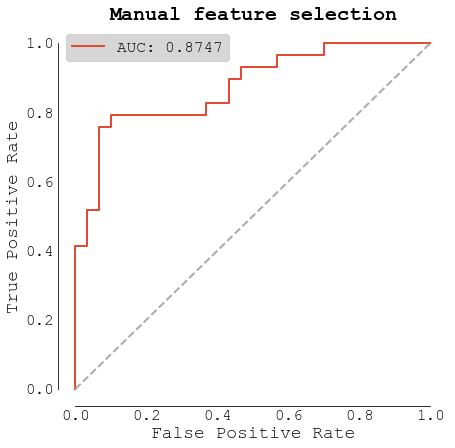

In [30]:
fpr, tpr, thresh = roc_curve(df_risk["Afib"], result.predict(df_risk))
plt.figure(figsize=(7, 7))
plt.plot(
    fpr,
    tpr,
    label=f"AUC: {roc_auc_score(df_risk['Afib'], result.predict(df_risk)):.4f}",
)
plt.plot([0, 1], [0, 1], color="#AAAAAA", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Manual feature selection")
plt.legend()
sns.despine(trim=True)
if SAVE_RESULTS:
    plt.savefig(
        os.path.join(RESULTS_FOLDER, "logres_all_data_medicalFS" + PLOTS_EXT),
        dpi=DPI,
        transparent=True,
        bbox_inches="tight",
    )

In [31]:
ideal_threshold_manual = thresh[np.argmax(tpr - fpr)]
print(f"Threshold: {ideal_threshold_manual}")
get_metrics_for_prediction(
    df_risk["Afib"], result.predict(df_risk) > ideal_threshold_manual
)

Threshold: 0.6332172114058331


,predicted FIB,predicted NO FIB
FIB,27,3
NO FIB,7,22


---------
Accuracy :  0.8305084745762712
Sensitivity :  0.9
Specificity :  0.7586206896551724


### CV Stratified K-Fold

In [32]:
df_logres = prepare_df(df, predictors)
print(f"Predictors: {', '.join(df_logres.columns)}")
x_data = df_logres.loc[:, df_logres.columns != "Afib"].values
y_data = df_logres["Afib"].values

N_FOLDS = 5
N_REPEATS = 20

tpr, fpr, auc = [], [], []
acc, sens, spec = [], [], []
thresholds = np.linspace(0, 1, 100)


def manual_roc_curve(true, pred):
    tpr = []
    fpr = []
    for thresh in thresholds:
        tn, fp, fn, tp = confusion_matrix(true, pred > thresh).ravel()
        tpr.append(tp / (tp + fn))
        fpr.append(fp / (fp + tn))
    return np.array(tpr), np.array(fpr)


# define Repeated Stratified K-Fold
rskf = RepeatedStratifiedKFold(n_splits=N_FOLDS, n_repeats=N_REPEATS)
# define classifier
clf = make_pipeline(
    StandardScaler(),
    LogisticRegression(penalty="elasticnet", solver="saga", l1_ratio=0.5, max_iter=500),
)

for train_index, test_index in rskf.split(x_data, y_data):
    x_train, x_test = x_data[train_index], x_data[test_index]
    y_train, y_test = y_data[train_index], y_data[test_index]
    clf.fit(x_train, y_train)
    probs = clf.predict_proba(x_test)[:, 1]
    tpr_, fpr_ = manual_roc_curve(y_test, probs)
    auc_ = roc_auc_score(y_test, probs)
    ideal_threshold_ = thresholds[np.argmax(tpr_ - fpr_)]
    metrics = get_metrics_for_kfold(y_test, probs > ideal_threshold_)
    tpr.append(tpr_)
    fpr.append(fpr_)
    auc.append(auc_)
    acc.append(metrics[0])
    sens.append(metrics[1])
    spec.append(metrics[2])

Predictors: TlakKrviDiastolicky, VaskularneOchorenieBod, Bmi, GZnamkySrdcovehoZlyhavania, TlakKrviSystolicky, DDimerUgMl, DiastolickaDysfunkciaIIiiStupna, Afib, DiabetesMellitusBod, NtProbnpNgL, Vek, CrpMgL, LChronickaObstrukcnaChorobaPluc, KreatininMmolL, ApelinNgMl, DPriemerLavejPredsieneVPlaxParasternalShortAxisMm, Pohlavie


---------
Accuracy: 0.700 ± 0.094
Sensitivity: 0.618 ± 0.257
Specificity: 0.786 ± 0.254


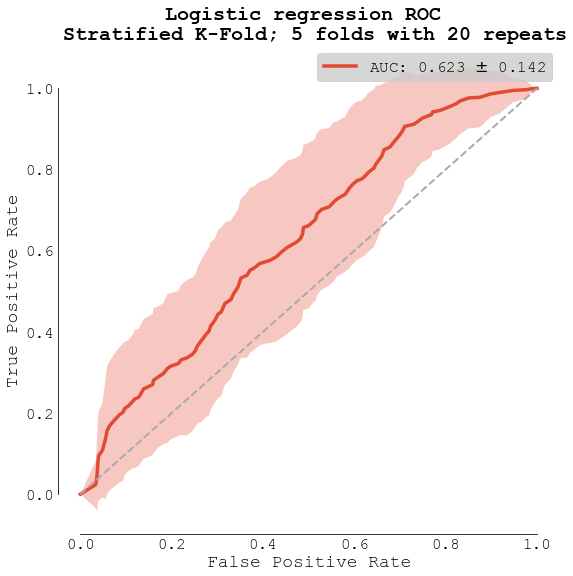

In [33]:
plt.figure(figsize=(9, 9))
tpr = np.vstack(tpr)
fpr = np.vstack(fpr)
mean_auc = np.mean(auc)
std_auc = np.std(auc)
plt.plot(
    fpr.mean(axis=0),
    tpr.mean(axis=0),
    label=f"AUC: {mean_auc:.3f} $\pm$ {std_auc:.3f}",
    linewidth=3.5,
)
plt.fill_between(
    fpr.mean(axis=0),
    tpr.mean(axis=0) - tpr.std(axis=0),
    tpr.mean(axis=0) + tpr.std(axis=0),
    alpha=0.3,
)
plt.plot([0, 1], [0, 1], color="#AAAAAA", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(
    f"Logistic regression ROC \n Stratified K-Fold; {N_FOLDS} folds with {N_REPEATS} repeats"
)
plt.legend()
sns.despine(trim=True)
if SAVE_RESULTS:
    plt.savefig(
        os.path.join(RESULTS_FOLDER, "logres_KFold_medicalFS" + PLOTS_EXT),
        dpi=DPI,
        transparent=True,
        bbox_inches="tight",
    )
    
print("---------")
print(f"Accuracy: {np.mean(acc):.3f} ± {np.std(acc):.3f}")
print(f"Sensitivity: {np.mean(sens):.3f} ± {np.std(sens):.3f}")
print(f"Specificity: {np.mean(spec):.3f} ± {np.std(spec):.3f}")

## Logistic regression from bivariate analysis
### All data with detailed results
* Bivariate analysis feature selection

In [34]:
PREDICTOR_THRESH = 0.1
predictors = set(list(overall[overall["p-value"] < PREDICTOR_THRESH].index) + ["Typ"])
predictors = list(
    predictors
    - set(
        [
            "Trvanie AFib (mesiace)",
            "Fructosamine[mmol/l]",
            "RAGE[pg/ml]",
            "AGEs[g/l]",
            "AGEs[rfu]",
            "i. Inhibítor protónovej pumpy",
            "k. Kyselina acetylsalicylová",
        ]
    )
)
df_bivar = prepare_df(df, predictors)
print(f"Predictors: {', '.join(df_bivar.columns)}")
result = logres_statsmodels(df_bivar)
if SAVE_RESULTS:
    statsmodels_summary_to_df(result).round(3).to_csv(
        os.path.join(RESULTS_FOLDER, "logres_bivarFS_summary.csv")
    )
result.summary()

Predictors: Afib, NtProbnpNgL, CrpMgL, ApelinNgMl, HsTroponinNgL


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   Afib   No. Observations:                   59
Model:                            GLM   Df Residuals:                       54
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -30.439
Date:                Wed, 08 Sep 2021   Deviance:                       60.877
Time:                        21:57:42   Pearson chi2:                     48.7
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.4090      0.542      0.755      0.450      -0.653       1.471
NtProbnpNgL       0.7772      0.469      1.657      0.097      -0.142       1.696
CrpMgL           -0.3214      0.378     -0.851      0.395      -1.061       0.418
HsTroponinNgL     3.9073      2.765      1.413      0.158      -1.512       9.327
ApelinNgMl       -1.0194      0.457     -2.230      0.026      -1.915      -0.123
=================================================================================
"""

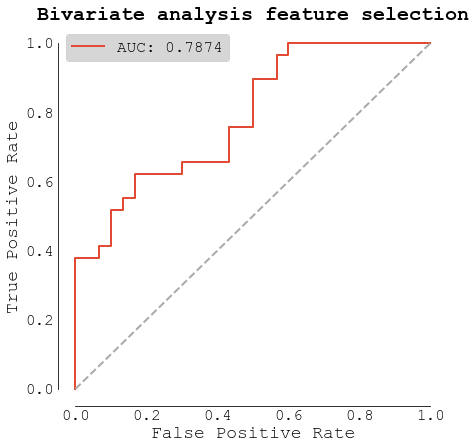

In [35]:
fpr, tpr, thresh = roc_curve(df_bivar["Afib"], result.predict(df_bivar))
plt.figure(figsize=(7, 7))
plt.plot(
    fpr,
    tpr,
    label=f"AUC: {roc_auc_score(df_bivar['Afib'], result.predict(df_bivar)):.4f}",
)
plt.plot([0, 1], [0, 1], color="#AAAAAA", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Bivariate analysis feature selection")
plt.legend()
sns.despine(trim=True)
if SAVE_RESULTS:
    plt.savefig(
        os.path.join(RESULTS_FOLDER, "logres_all_data_bivarFS" + PLOTS_EXT),
        dpi=DPI,
        transparent=True,
        bbox_inches="tight",
    )

In [36]:
ideal_threshold_bivar = thresh[np.argmax(tpr - fpr)]
print(f"Threshold: {ideal_threshold_bivar}")
get_metrics_for_prediction(
    df_bivar["Afib"], result.predict(df_bivar) > ideal_threshold_bivar
)

Threshold: 0.5721753523810446


,predicted FIB,predicted NO FIB
FIB,25,5
NO FIB,12,17


---------
Accuracy :  0.711864406779661
Sensitivity :  0.8333333333333334
Specificity :  0.5862068965517241


### CV with Stratified K-Fold

In [37]:
df_logres = prepare_df(df, predictors)
print(f"Predictors: {', '.join(df_logres.columns)}")
x_data = df_logres.loc[:, df_logres.columns != "Afib"].values
y_data = df_logres["Afib"].values

N_FOLDS = 5
N_REPEATS = 20

tpr, fpr, auc = [], [], []
acc, sens, spec = [], [], []
thresholds = np.linspace(0, 1, 100)


def manual_roc_curve(true, pred):
    tpr = []
    fpr = []
    for thresh in thresholds:
        tn, fp, fn, tp = confusion_matrix(true, pred > thresh).ravel()
        tpr.append(tp / (tp + fn))
        fpr.append(fp / (fp + tn))
    return np.array(tpr), np.array(fpr)


# define Repeated Stratified K-Fold
rskf = RepeatedStratifiedKFold(n_splits=N_FOLDS, n_repeats=N_REPEATS)
# define classifier
clf = make_pipeline(
    StandardScaler(),
    LogisticRegression(penalty="elasticnet", solver="saga", l1_ratio=0.5, max_iter=500),
)

for train_index, test_index in rskf.split(x_data, y_data):
    x_train, x_test = x_data[train_index], x_data[test_index]
    y_train, y_test = y_data[train_index], y_data[test_index]
    clf.fit(x_train, y_train)
    probs = clf.predict_proba(x_test)[:, 1]
    tpr_, fpr_ = manual_roc_curve(y_test, probs)
    auc_ = roc_auc_score(y_test, probs)
    ideal_threshold_ = thresholds[np.argmax(tpr_ - fpr_)]
    metrics = get_metrics_for_kfold(y_test, probs > ideal_threshold_)
    tpr.append(tpr_)
    fpr.append(fpr_)
    auc.append(auc_)
    acc.append(metrics[0])
    sens.append(metrics[1])
    spec.append(metrics[2])

Predictors: Afib, NtProbnpNgL, CrpMgL, ApelinNgMl, HsTroponinNgL


---------
Accuracy: 0.756 ± 0.092
Sensitivity: 0.642 ± 0.233
Specificity: 0.875 ± 0.178


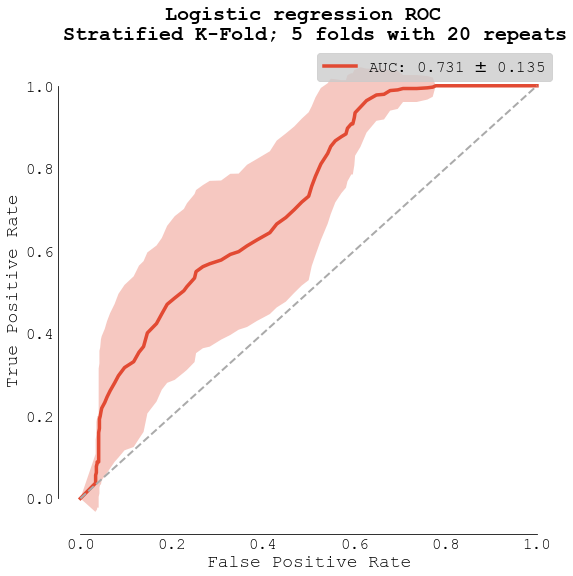

In [38]:
plt.figure(figsize=(9, 9))
tpr = np.vstack(tpr)
fpr = np.vstack(fpr)
mean_auc = np.mean(auc)
std_auc = np.std(auc)
plt.plot(
    fpr.mean(axis=0),
    tpr.mean(axis=0),
    label=f"AUC: {mean_auc:.3f} $\pm$ {std_auc:.3f}",
    linewidth=3.5,
)
plt.fill_between(
    fpr.mean(axis=0),
    tpr.mean(axis=0) - tpr.std(axis=0),
    tpr.mean(axis=0) + tpr.std(axis=0),
    alpha=0.3,
)
plt.plot([0, 1], [0, 1], color="#AAAAAA", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(
    f"Logistic regression ROC \n Stratified K-Fold; {N_FOLDS} folds with {N_REPEATS} repeats"
)
plt.legend()
sns.despine(trim=True)
if SAVE_RESULTS:
    plt.savefig(
        os.path.join(RESULTS_FOLDER, "logres_KFold_bivarFS" + PLOTS_EXT),
        dpi=DPI,
        transparent=True,
        bbox_inches="tight",
    )
    
    
print("---------")
print(f"Accuracy: {np.mean(acc):.3f} ± {np.std(acc):.3f}")
print(f"Sensitivity: {np.mean(sens):.3f} ± {np.std(sens):.3f}")
print(f"Specificity: {np.mean(spec):.3f} ± {np.std(spec):.3f}")